<a href="https://colab.research.google.com/github/sjoshiAI/Generative_AI/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks, metrics, losses, optimizers
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from zipfile import ZipFile

In [2]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
def preprocess(imgs):
    imgs = imgs.astype("float32")/255.
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs

In [4]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
class Sampling(layers.Layer):
    """samples z from z_mean and z_log_var"""
    def call(self,inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(z_log_var*0.5)*epsilon


In [6]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [ ]:
encoder_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1), name="encoder_input")
x = layers.Conv2D(32, (3,3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3,3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean,z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
shape_before_flattening

(4, 4, 128)

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
decoder_input = layers.Input(shape = (EMBEDDING_DIM, ), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

In [7]:
class VAE(models.Model):
    "VAE model"
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker
                ]

    def call(self,inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(500* losses.binary_crossentropy(data, reconstruction, axis=(1,2,3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(x_train,
        epochs=10,
        batch_size=128
        )

In [ ]:
z_mean, z_log_var, reconstructions = vae.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [8]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

Example real clothing items


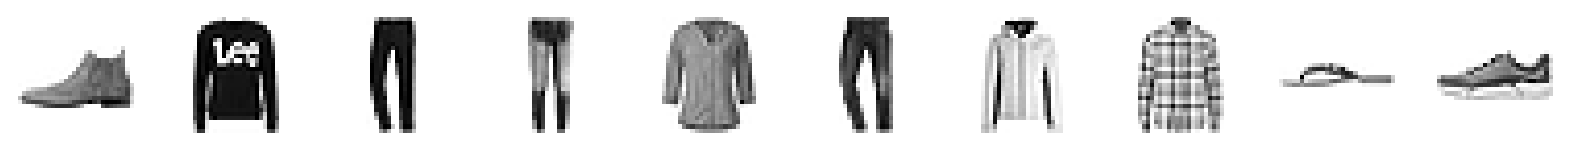

Reconstructions


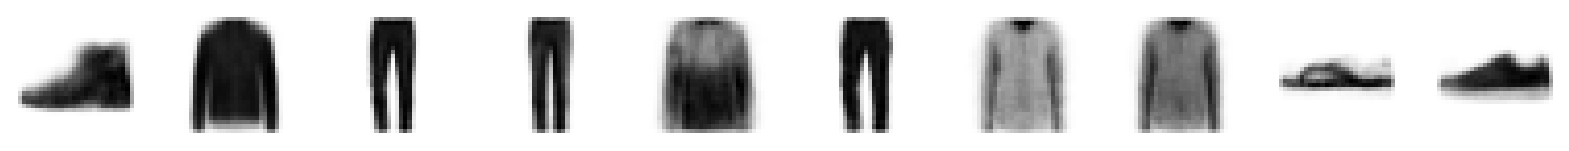

In [ ]:
print("Example real clothing items")
display(x_test)
print("Reconstructions")
display(reconstructions)

In [ ]:
z_mean, z_var, z = encoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


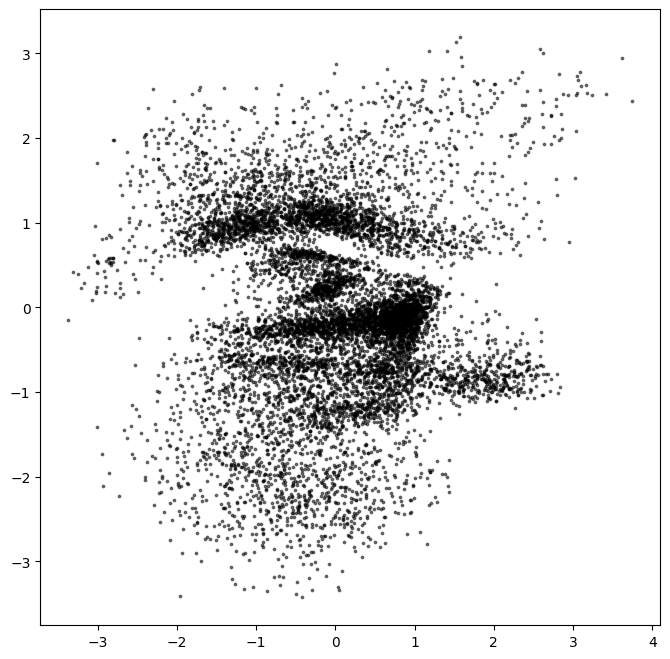

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 200ms/step


In [ ]:
from scipy.stats import norm

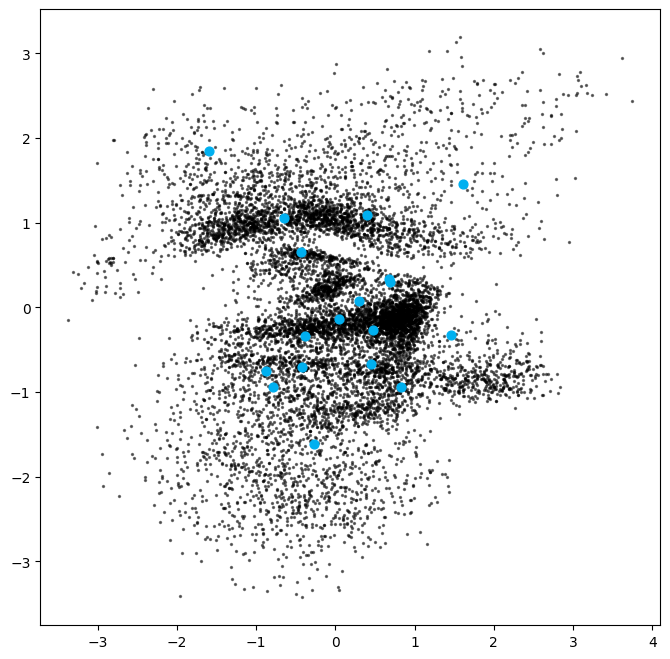

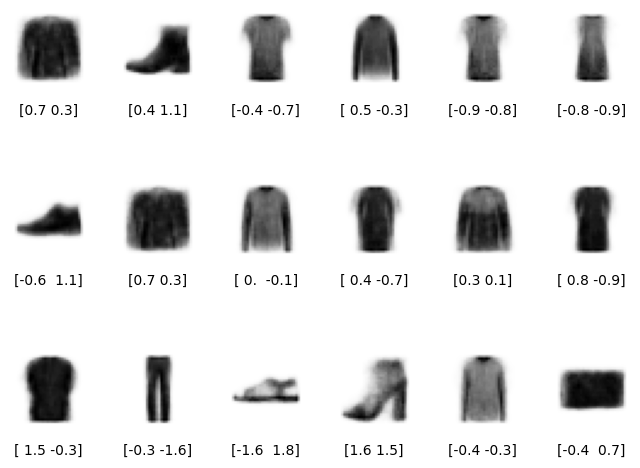

In [ ]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# CelebA Dataset

In [9]:
import os, gdown
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [11]:
dataset = keras.utils.image_dataset_from_directory("celeba_gan", labels=None,color_mode="rgb",
    image_size=(64, 64),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation="bilinear")
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


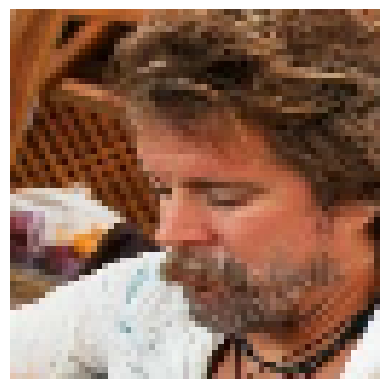

In [12]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [13]:
IMAGE_SIZE = 64
Z_DIM = 200
CHANNELS = 3
NUM_FEATURES=64
LEARNING_RATE=0.0005

In [14]:
# Encoder
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")
x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)           0         ['batch_normalization[0]

In [15]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    256, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    64, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    32, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 1024)              205824    
                                                                 
 batch_normalization_5 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         590080    
 anspose)                                                    

In [16]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)
vae.fit(dataset,
        epochs=50,
        batch_size=64
        )

Epoch 1/50
1583/1583 [==============================] - 131s 71ms/step - total_loss: 291.4904 - reconstruction_loss: 281.7928 - kl_loss: 9.6978
Epoch 2/50
1583/1583 [==============================] - 110s 69ms/step - total_loss: 284.2380 - reconstruction_loss: 272.6688 - kl_loss: 11.5686
Epoch 3/50
1583/1583 [==============================] - 110s 69ms/step - total_loss: 283.1920 - reconstruction_loss: 271.0937 - kl_loss: 12.0983
Epoch 4/50
1583/1583 [==============================] - 110s 69ms/step - total_loss: 282.8347 - reconstruction_loss: 270.6547 - kl_loss: 12.1799
Epoch 5/50
1583/1583 [==============================] - 110s 69ms/step - total_loss: 282.6360 - reconstruction_loss: 270.3873 - kl_loss: 12.2489
Epoch 6/50
1583/1583 [==============================] - 110s 69ms/step - total_loss: 282.4558 - reconstruction_loss: 270.1222 - kl_loss: 12.3333
Epoch 7/50
1583/1583 [==============================] - 110s 69ms/step - total_loss: 282.3042 - reconstruction_loss: 269.8927 - kl_

In [17]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(dataset.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 0s 12ms/step
Example real faces


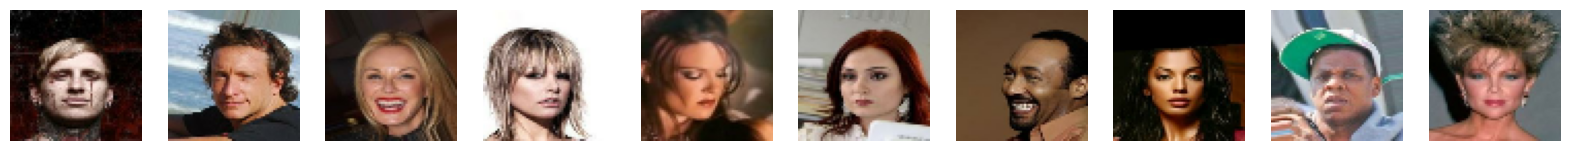

Reconstructions


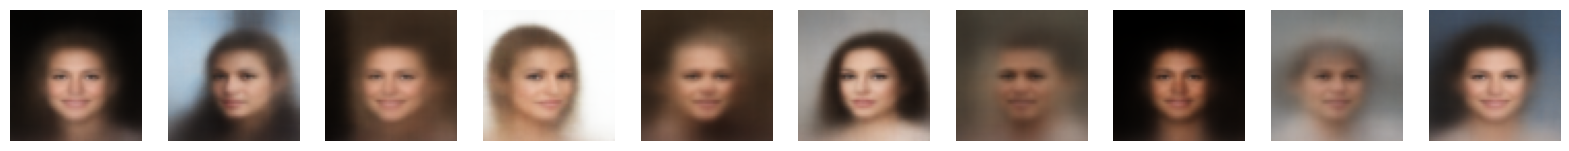

In [20]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

1/1 [==============================] - 1s 985ms/step


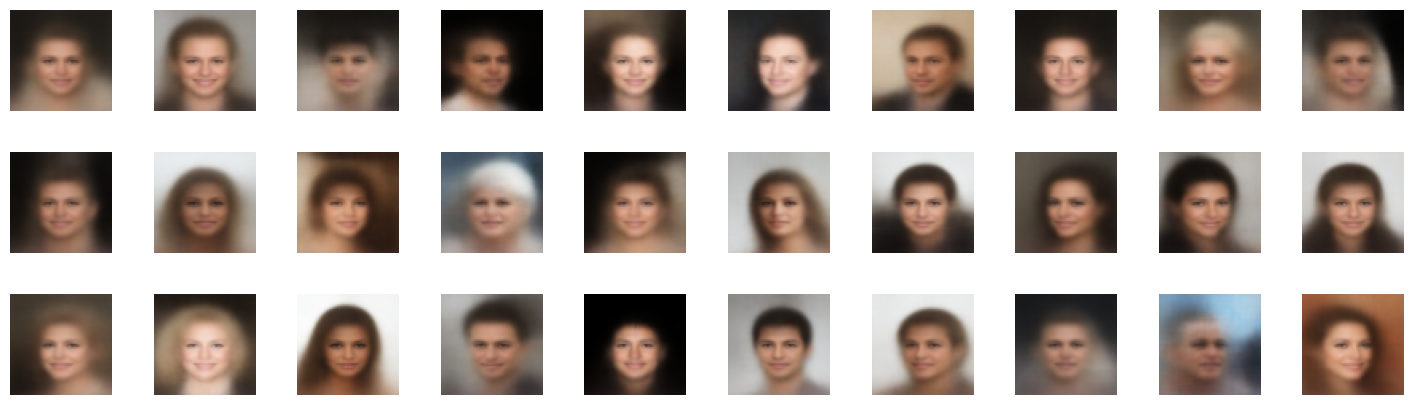

In [19]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

# Decode the sampled points
reconstructions = decoder.predict(z_sample)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])